In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
import os
from PIL import Image
from pickle import dump, load
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset

In [2]:
# # Step 1: Load and preprocess images
# def load_images(images_folder, save_file_to=None):
#     X_original = []
#     X = []
#     y = []

#     for subdir, dirs, files in os.walk(images_folder):
#         for file in files:
#             if file.endswith(('jpg', 'jpeg', 'png')):
#                 img_path = os.path.join(subdir, file)
#                 label = os.path.basename(subdir)

#                 image = Image.open(img_path).convert('L')  # Convert to grayscale
#                 image = image.resize((48, 48))  # Resize to 48x48
#                 X_original.append(np.array(image).flatten())
#                 X.append(np.array(image).flatten())
#                 y.append(label)

#     if save_file_to:
#         with open(save_file_to, "wb") as f:
#             dump((X_original, X, y), f, protocol=5)

#     return np.array(X_original), np.array(X), np.array(y)

# images_folder = "../images"
# dataset_file = "dataset_dump.pkl"


# X_original, X, y = load_images(images_folder, save_file_to=dataset_file)

In [3]:
with open("dataset_dump.pkl", "rb") as f:
    X_original,X,y = load(f)
    
X
y

['angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',


In [4]:
# Convert lists to NumPy arrays
X = np.array(X)
y = np.array(y)

In [5]:
# # Preprocessing data function
# def preprocessing_data(X, y, save_file_to=None):
#     # Normalize pixel values
#     X = X / 255.0  # Normalize to [0, 1]

#     # Encode labels
#     label_encoder = LabelEncoder()
#     y_encoded = label_encoder.fit_transform(y)

#     # Standardize the data
#     scaler = StandardScaler()
#     X_scaled = scaler.fit_transform(X)

#     # Apply PCA for dimensionality reduction
#     pca = PCA(n_components=100)  # Adjust the number of components as needed
#     X_pca = pca.fit_transform(X_scaled)

#     if save_file_to:
#         with open(save_file_to, "wb") as f:
#             dump((X_pca, y_encoded, label_encoder, scaler), f, protocol=5)

#     return X_pca, y_encoded, label_encoder, scaler

# # Process the data and save
# X_pca, y_encoded, label_encoder, scaler = preprocessing_data(X, y, save_file_to="preprocessed_data.pkl")

In [6]:
with open("preprocessed_data.pkl", "rb") as f:
    X_pca, y_encoded, label_encoder, scaler = load(f)

In [7]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_pca, y_encoded, test_size=0.2, random_state=42)


In [8]:
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

In [9]:
# Custom dataset to handle PCA data
class CustomDataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        # Reshape the PCA data as an image for visualization purposes
        image = self.X[idx].reshape(10, 10)  # Example reshape (adjust based on PCA output)
        
        # Apply the transformation if defined
        if self.transform:
            image = self.transform(image)

        label = self.y[idx]
        # Ensure the image is of type float32
        return image.type(torch.float32), label  # This line is added

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(p=0.5),  # Flip with 50% probability
    transforms.RandomRotation(5),  # Limit rotation to ±5 degrees
    transforms.RandomAffine(degrees=5, translate=(0.1, 0.1)),  # Reduce affine transformations
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Validation/Test transform
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Train and Validation DataLoader
train_dataset = CustomDataset(X_train, y_train, transform=transform)
val_dataset = CustomDataset(X_val, y_val, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)



In [10]:
class SimpleNN(nn.Module):
    def __init__(self, input_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 512)  # Increased neurons
        self.fc2 = nn.Linear(512, 256)        # Added extra layer
        self.fc3 = nn.Linear(256, len(np.unique(y_encoded)))  # Output layer
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))  # Apply relu after the second layer
        x = self.dropout(x)
        x = self.fc3(x)
        return x


In [11]:
# Initialize the model, loss function, and optimizer
criterion = nn.CrossEntropyLoss()

# Hyperparameter grid
param_grid = {
    'lr': [0.001, 0.0005, 0.0001],
    'dropout': [0.5, 0.3],
    'batch_size': [32, 64],
}

grid_search = ParameterGrid(param_grid)

# Iterate through each combination of hyperparameters
for params in grid_search:
    print(f"Training with params: {params}")
    
    # Initialize model with specific dropout
    model = SimpleNN(input_size=100)
    
    # Optimizer with the specified learning rate
    optimizer = optim.Adam(model.parameters(), lr=params['lr'])
    
    # DataLoader with the specified batch size
    train_loader = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True)
    
    # Scheduler
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

    # Training loop for the current parameter combination
    num_epochs = 100
    for epoch in range(num_epochs):
        model.train()
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images.view(images.size(0), -1))  # Flatten images for FC layer
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        
        scheduler.step()

        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")
    
    print("Finished training with current parameter combination.\n")

    # Evaluation and prediction
    model.eval()
    with torch.no_grad():
        outputs = model(X_test_tensor)
        _, predicted = torch.max(outputs.data, 1)
        y_pred = predicted.numpy()

    # Calculate accuracy and print classification report
    accuracy = accuracy_score(y_test_tensor.numpy(), y_pred)
    print(f"Accuracy for params {params}: {accuracy:.2f}")
    print("Classification Report:")
    print(classification_report(y_test_tensor.numpy(), y_pred, target_names=label_encoder.classes_))
    print("-" * 50)


Training with params: {'batch_size': 32, 'dropout': 0.5, 'lr': 0.001}
Epoch [10/100], Loss: 1.8288
Epoch [20/100], Loss: 1.7113
Epoch [30/100], Loss: 1.6113
Epoch [40/100], Loss: 2.0510
Epoch [50/100], Loss: 1.2821
Epoch [60/100], Loss: 1.2718
Epoch [70/100], Loss: 1.9181
Epoch [80/100], Loss: 1.5351
Epoch [90/100], Loss: 1.2701
Epoch [100/100], Loss: 1.2005
Finished training with current parameter combination.

Accuracy for params {'batch_size': 32, 'dropout': 0.5, 'lr': 0.001}: 0.35
Classification Report:
              precision    recall  f1-score   support

       angry       0.51      0.05      0.09      1963
     disgust       0.50      0.00      0.01       217
        fear       0.32      0.10      0.16      2064
       happy       0.32      0.89      0.47      3590
     neutral       0.52      0.19      0.28      2504
         sad       0.30      0.26      0.28      2417
    surprise       0.83      0.31      0.45      1600

    accuracy                           0.35     14355

C:\Users\shane_1\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\shane_1\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\shane_1\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

Epoch [10/100], Loss: 1.8580
Epoch [20/100], Loss: 1.4730
Epoch [30/100], Loss: 1.3723
Epoch [40/100], Loss: 0.9524
Epoch [50/100], Loss: 1.5287
Epoch [60/100], Loss: 1.8975
Epoch [70/100], Loss: 1.3317
Epoch [80/100], Loss: 1.4511
Epoch [90/100], Loss: 1.4375
Epoch [100/100], Loss: 1.6914
Finished training with current parameter combination.

Accuracy for params {'batch_size': 32, 'dropout': 0.3, 'lr': 0.0005}: 0.39
Classification Report:
              precision    recall  f1-score   support

       angry       0.53      0.08      0.13      1963
     disgust       1.00      0.01      0.02       217
        fear       0.40      0.13      0.19      2064
       happy       0.34      0.92      0.50      3590
     neutral       0.41      0.32      0.36      2504
         sad       0.41      0.19      0.26      2417
    surprise       0.83      0.34      0.48      1600

    accuracy                           0.39     14355
   macro avg       0.56      0.28      0.28     14355
weighted avg  

C:\Users\shane_1\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\shane_1\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\shane_1\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

Epoch [10/100], Loss: 1.7693
Epoch [20/100], Loss: 1.6741
Epoch [30/100], Loss: 1.3805
Epoch [40/100], Loss: 1.4296
Epoch [50/100], Loss: 1.5849
Epoch [60/100], Loss: 1.3662
Epoch [70/100], Loss: 1.2168
Epoch [80/100], Loss: 1.8232
Epoch [90/100], Loss: 1.3425
Epoch [100/100], Loss: 1.0985
Finished training with current parameter combination.

Accuracy for params {'batch_size': 64, 'dropout': 0.3, 'lr': 0.0005}: 0.38
Classification Report:
              precision    recall  f1-score   support

       angry       0.60      0.08      0.13      1963
     disgust       1.00      0.02      0.05       217
        fear       0.44      0.12      0.19      2064
       happy       0.33      0.93      0.49      3590
     neutral       0.42      0.28      0.34      2504
         sad       0.40      0.18      0.25      2417
    surprise       0.80      0.36      0.50      1600

    accuracy                           0.38     14355
   macro avg       0.57      0.28      0.28     14355
weighted avg  

C:\Users\shane_1\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\shane_1\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\shane_1\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

In [12]:
# Evaluation and prediction
model.eval()
with torch.no_grad():
    outputs = model(X_test_tensor)
    _, predicted = torch.max(outputs.data, 1)
    y_pred = predicted.numpy()

# Calculate accuracy and print classification report
accuracy = accuracy_score(y_test_tensor.numpy(), y_pred)
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(classification_report(y_test_tensor.numpy(), y_pred, target_names=label_encoder.classes_))

Accuracy: 0.40
Classification Report:
              precision    recall  f1-score   support

       angry       0.53      0.08      0.14      1963
     disgust       0.00      0.00      0.00       217
        fear       0.42      0.10      0.16      2064
       happy       0.36      0.91      0.51      3590
     neutral       0.40      0.33      0.36      2504
         sad       0.41      0.22      0.29      2417
    surprise       0.71      0.43      0.54      1600

    accuracy                           0.40     14355
   macro avg       0.40      0.30      0.29     14355
weighted avg       0.44      0.40      0.34     14355



C:\Users\shane_1\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\shane_1\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\shane_1\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

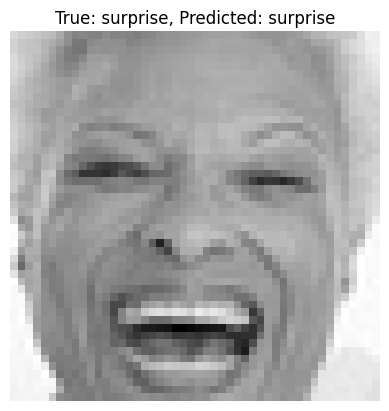

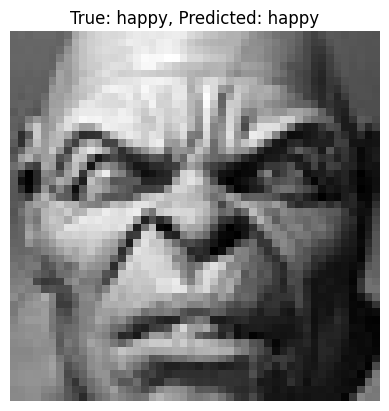

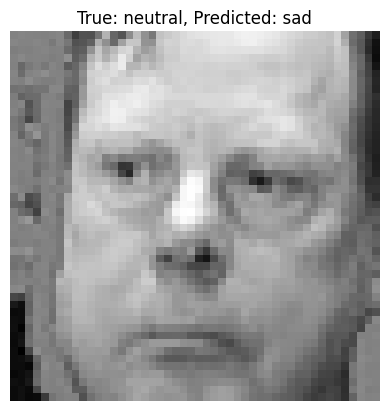

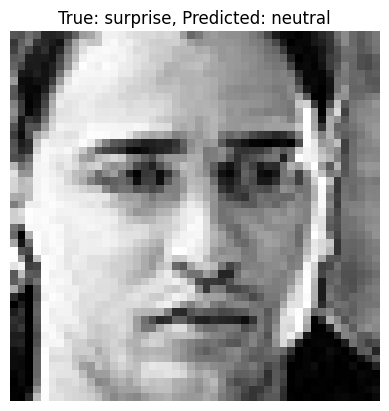

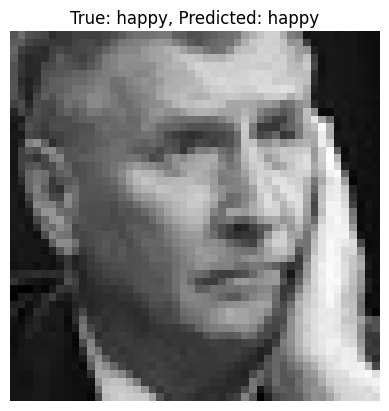

In [13]:
# Visualize predictions
def visualize_predictions(model, X_test, y_test, label_encoder, X_original):
    model.eval()
    with torch.no_grad():
        outputs = model(X_test)
        _, y_pred = torch.max(outputs.data, 1)

    random_indices = np.random.randint(0, len(y_test), 5)

    for idx in random_indices:
        original_image = X_original[idx].reshape(48, 48)  # Reshape original image for visualization
        plt.imshow(original_image, cmap='gray')
        plt.title(f"True: {label_encoder.inverse_transform([y_test[idx]])[0]}, "
                  f"Predicted: {label_encoder.inverse_transform([y_pred[idx]])[0]}")
        plt.axis('off')
        plt.show()

# Call visualization function
visualize_predictions(model, X_test_tensor, y_test_tensor, label_encoder, X_original)